In [3]:
import sys
sys.path.append('../../code')
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sbi import inference as sbi_inference
from utils import (linear_scale_array, UniformPrior,
                   get_dataset_psd, get_dataset_peaks, load_posterior, simulator_hnn,
                   get_parameter_recovery, get_posterior_predictive_check, hnn_beta_param_function)
from hnn_core import jones_2009_model
from functools import partial
import dill
from sbi import utils as sbi_utils
import pandas as pd
from sklearn.decomposition import PCA
rng_seed = 123

scale_factor = 60_000

sns.set()
sns.set_style("white")

device = 'cpu'

sim_type = 'hnn_beta'
data_path = f'../../data/{sim_type}'

with open(f'{data_path}/posteriors/posterior_dicts.pkl', 'rb') as output_file:
    posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)
with open(f'{data_path}/posteriors/posterior_metadata.pkl', 'rb') as output_file:
    posterior_metadata = dill.load(output_file)
    
dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation
window_samples = posterior_metadata['window_samples'] 

net = jones_2009_model()

simulator = partial(simulator_hnn, prior_dict=prior_dict, param_function=hnn_beta_param_function,
                    network_model=net, tstop=tstop, return_objects=True)

In [4]:
import sys
sys.path.append('../../code')
import numpy as np
from utils import UniformPrior, linear_scale_forward
rng_seed = 123
rng = np.random.default_rng(rng_seed)

In [5]:
prior_dict = {'amp1': {'bounds': (0, 1), 'scale_func': linear_scale_forward},
              'amp2': {'bounds': (0, 1), 'scale_func': linear_scale_forward}, 
              'latency': {'bounds': (-75, 75), 'scale_func': linear_scale_forward}}

# Create uniform prior and sample
prior = UniformPrior(parameters=list(prior_dict.keys()))

In [8]:
# Values on [0,1] mapped to range of bounds defined in prior_dict
theta_cond_list = [np.array([0.15, 0.75, 0.95, 0.95]), np.array([0.75, 0.75, 0.95, 0.95])]

x_cond_list, theta_dict_list, net_list = list(), list(), list()
prox_times_list, dist_times_list = list(), list()
for theta_cond in theta_cond_list:
    theta_dict = {param_name: param_dict['scale_func'](theta_cond[idx], param_dict['bounds']) for 
                  idx, (param_name, param_dict) in enumerate(prior_dict.items())}

    net, dpl = simulator(torch.tensor(theta_cond).float())[0]
    x_cond = dpl[0].copy().smooth(20).data['agg']
        
    theta_dict_list.append(theta_dict)
    x_cond_list.append(x_cond)
    net_list.append(net)
    
    net_idx = 0
    spike_times = np.array(net.cell_response.spike_times)
    spike_types = np.array(net.cell_response.spike_types)
    prox_times = spike_times[spike_types == 'beta_prox']
    dist_times = spike_times[spike_types == 'beta_dist']
    
    prox_times_list.append(prox_times)
    dist_times_list.append(dist_times)



{'dist_var': 3.0000001192092896, 'prox_var': 35.0, 'dist_exc': 8.912509136698405e-06, 'prox_exc': 8.912509136698405e-06}
joblib will run over 1 jobs
Loading custom mechanism files from /home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.5 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Simulation time: 170.0 ms...
Simulation time: 180.0 ms...
Simulation time: 190.0 ms...
Simulation time: 200.0 ms...
Simulation time: 210.0 ms...
Simulation time: 220.0 ms..

In [4]:
small_idx = 7799
large_idx = 1799
n_val = 10
input_type = 'pca4'
x_val, theta_grid = np.load(f'{data_path}/sbi_sims/x_{input_type}_validation.npy'), np.load(f'{data_path}/sbi_sims/theta_grid.npy')

print(theta_grid[small_idx,:], theta_grid[large_idx,:])

small_start, small_stop = small_idx * n_val, small_idx * n_val + n_val
large_start, large_stop = large_idx * n_val, large_idx * n_val + n_val

x_small_val = x_val[small_start:small_stop, :]
x_large_val = x_val[large_start:large_stop, :]

[0.75 0.75 0.95 0.95] [0.15 0.75 0.95 0.95]


NameError: name 'x_large_val' is not defined

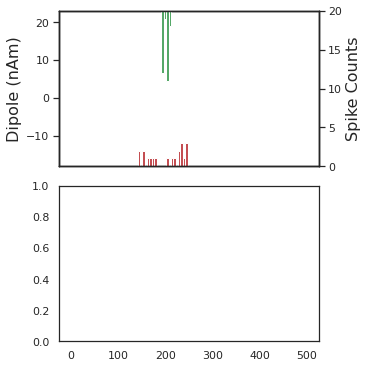

In [9]:
%matplotlib inline
bins = np.linspace(0,tstop,100)

labelsize = 16
titlesize=22

offset_samples = 0

waveform_ylim = [-18, 23]
hist_ylim = [0, 20]
# Plot conditioning features    
t_vec = np.linspace(0, tstop, x_cond_list[0].squeeze().shape[0])

time_lim = [145, 270]

fig, axes = plt.subplots(2,1,figsize=(5,5), constrained_layout=True, sharex=True)

# Top panel
axes[0].set_ylabel('Dipole (nAm)', fontsize=labelsize)
axes[0].set_ylim(waveform_ylim)
ax_top_prox = axes[0].twinx()
ax_top_prox.set_ylim(hist_ylim)
ax_top_dist = axes[0].twinx()
ax_top_dist.set_ylim(hist_ylim)
ax_top_waveform = axes[0].twinx()
ax_top_waveform.set_ylim(waveform_ylim)
ax_top_prox.hist(prox_times_list[0], color='C3', label='Proximal', bins=bins)
ax_top_dist.hist(dist_times_list[0], color='C2', label='Distal', bins=bins)
ax_top_dist.set_ylim(hist_ylim[-1], hist_ylim[0])

ax_top_prox.set_ylabel('Spike Counts', fontsize=labelsize)
ax_top_dist.set_yticklabels('')
ax_top_waveform.set_yticklabels('')
ax_top_dist.set_yticks([])
ax_top_waveform.set_yticks([])

_ = ax_top_waveform.plot(t_vec, x_large_val.T * scale_factor, linewidth=0.5, color='k', alpha=1.0)

ax_top_waveform.plot(t_vec, x_cond_list[0].squeeze() * scale_factor, linewidth=4, color='C0')
#axes[0].set_title('Condition 1', fontsize=titlesize)

# Bottom Panel
axes[1].set_ylabel('Dipole (nAm)', fontsize=labelsize)
axes[1].set_ylim(waveform_ylim)
ax_bottom_prox = axes[1].twinx()
ax_bottom_prox.set_ylim(hist_ylim)
ax_bottom_dist = axes[1].twinx()
ax_bottom_dist.set_ylim(hist_ylim)
ax_bottom_waveform = axes[1].twinx()
ax_bottom_waveform.set_ylim(waveform_ylim)
ax_bottom_prox.hist(prox_times_list[1], color='C3', label='Proximal', bins=bins)
ax_bottom_dist.hist(dist_times_list[1], color='C2', label='Distal', bins=bins)
ax_bottom_dist.set_ylim(hist_ylim[-1], hist_ylim[0])

ax_bottom_prox.set_ylabel('Spike Counts', fontsize=labelsize)
ax_bottom_dist.set_yticklabels('')
ax_bottom_waveform.set_yticklabels('')
ax_bottom_dist.set_yticks([])
ax_bottom_waveform.set_yticks([])

_ = ax_bottom_waveform.plot(t_vec, x_small_val.T * scale_factor, linewidth=0.5, color='k', alpha=1.0)
ax_bottom_waveform.plot(t_vec, x_cond_list[1].squeeze() * scale_factor, linewidth=4, color='C1')

axes[1].set_xlabel('Time (ms)', fontsize=labelsize)

axes[0].set_xlim(time_lim)
axes[0].set_xticklabels((axes[0].get_xticks() - axes[0].get_xticks()[0]).astype(int))


#plt.savefig('hnn_beta_cond_inputs.svg')